## Cape Cod - Detailed step-by-step

### Standardize, clean and wrangle Water Quality Portal data in Cape Cod into more analytic-ready formats using the harmonize_wq package

US EPA’s Water Quality Portal (WQP) aggregates water quality, biological, and physical data provided by many organizations and has become an essential resource with tools to query and retrieval data using python or R. Given the variety of data and variety of data originators, using the data in analysis often requires data cleaning to ensure it meets the required quality standards and data wrangling to get it in a more analytic-ready format. Recognizing the definition of analysis-ready varies depending on the analysis, the harmonixe_wq package is intended to be a flexible water quality specific framework to help:
- Identify differences in data units (including speciation and basis)
- Identify differences in sampling or analytic methods
- Resolve data errors using transparent assumptions
- Reduce data to the columns that are most commonly needed
- Transform data from long to wide format

Domain experts must decide what data meets their quality standards for data comparability and any thresholds for acceptance or rejection.

### Detailed step-by-step workflow

This example workflow takes a deeper dive into some of the expanded functionality to examine results for different water quality parameters in Cape Cod

#### Install and import the required libraries

In [1]:
import sys
#! python -m pip uninstall harmonize-wq --yes
# Use pip to install the package from pypi or the latest from github
#!{sys.executable} -m pip install harmonize-wq
# For latest dev version
#!{sys.executable} -m pip install git+https://github.com/USEPA/harmonize-wq.git

In [2]:
import dataretrieval.wqp as wqp
from harmonize_wq import wrangle
from harmonize_wq import location
from harmonize_wq import harmonize
from harmonize_wq import visualize
from harmonize_wq import clean

#### Download location data using dataretrieval

<Axes: >

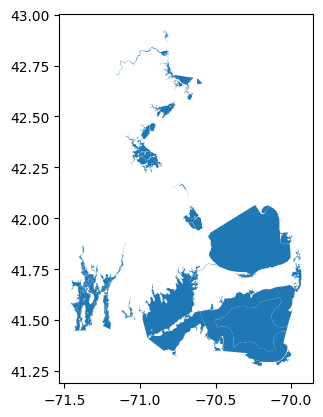

In [3]:
# Read geometry for Area of Interest from geojson file url and plot
aoi_url = 'https://github.com/jbousquin/test_notebook/raw/main/temperature_data/NewEngland.geojson'
aoi_gdf = wrangle.as_gdf(aoi_url)  # Already 4326 standard
aoi_gdf.plot()

In [4]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = wrangle.get_bounding_box(aoi_gdf)

In [5]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [6]:
# Rows and columns for results
stations.shape

(10568, 37)

In [7]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,AquiferName,LocalAqfrName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-MA,USGS Massachusetts Water Science Center,USGS-010965305,MERRIMACK R NR TYNGSBOROUGH BRIDGE TYNGSBOROUG...,Stream,NaN,1070006.0,4070.00,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096544,"STONY BROOK AT SCHOOL STREET AT CHELMSFORD, MA",Stream,NaN,1070006.0,41.57,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096546,"STONY BROOK AT CHELMSFORD, MA",Stream,NaN,1070006.0,43.60,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096548,"STONY BROOK AT N CHELMSFORD, MA",Stream,NaN,1070006.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096550,"MERRIMACK RIVER ABOVE LOWELL, MA",Stream,NaN,1070006.0,3900.00,sq mi,3900.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [8]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName        NAD83
LatitudeMeasure                                 42.677389
LongitudeMeasure                               -71.421056
Name: 0, dtype: object

In [9]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = location.harmonize_locations(stations, outEPSG=4326, intermediate_columns=True)

In [10]:
# Every function has a dostring to help understand input/output and what it does
location.harmonize_locations?

Signature:
location.harmonize_locations(
    df_in,
    out_EPSG=4326,
    intermediate_columns=False,
    **kwargs,
)
Docstring:
Create harmonized geopandas GeoDataframe from pandas DataFrame.

Takes a :class:`~pandas.DataFrame` with lat/lon in multiple Coordinate
Reference Systems (CRS), transforms them to out_EPSG CRS, and converts to
:class:`geopandas.GeoDataFrame`. A 'QA_flag' column is added to the result
and populated for any row that has location based problems like limited
decimal precision or an unknown input CRS.

Parameters
----------
df_in : pandas.DataFrame
    DataFrame with the required columns (see kwargs for expected defaults)
    to be converted to GeoDataFrame.
out_EPSG : int, optional
    EPSG factory code for desired output Coordinate Reference System datum.
    The default is 4326, for the WGS84 Datum used by WQP queries.
intermediate_columns : Boolean, optional
    Return intermediate columns. Default 'False' does not return these.
**kwargs: optional
   Accepts 

In [11]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(10568, 42)

In [12]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-71.4210556, 42.67738889)
EPSG                                  4269.0
QA_flag                                  NaN
geom         POINT (-71.4210556 42.67738889)
geometry     POINT (-71.4210556 42.67738889)
Name: 0, dtype: object

In [13]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [14]:
# Look at the different QA_flag flags that have been assigned,
# e.g., for bad datums or limited decimal precision
set(stations_gdf.loc[stations_gdf['QA_flag'].notna()]['QA_flag'])

{'HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed',
 'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits'}

<Axes: >

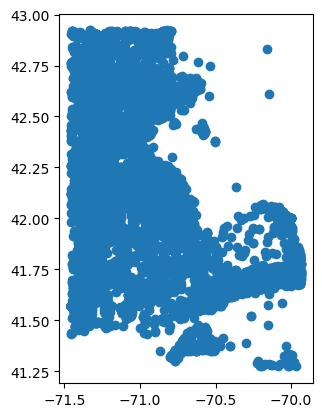

In [15]:
# Map it
stations_gdf.plot()

In [16]:
# Clip to area of interest
stations_clipped = wrangle.clip_stations(stations_gdf, aoi_gdf)

<Axes: >

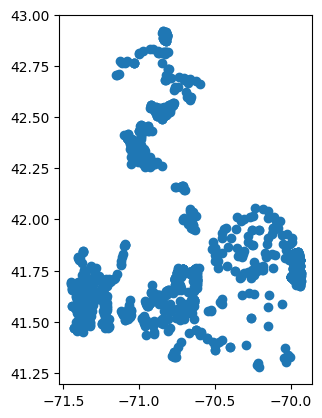

In [17]:
# Map it
stations_clipped.plot()

In [18]:
# How many stations now?
len(stations_clipped)

1519

In [19]:
# To save the results to a shapefile
#import os
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(path,'CapeCod_stations.shp'))

#### Retrieve Characteristic Data

In [20]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\dataretrieval\wqp.py:83: DtypeWarning: Columns (8,10,13,15,17,19,20,21,22,23,28,31,32,33,34,36,38,60,62,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=',')


In [21]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-CACO_HX30_21_7/22/2013_SFW_0.01,2013-07-22,11:01:00,EDT,11NPSWRD_WQX-CACO_HX30_21,STORET-986369728,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,MASSDEP,Massachusetts Department of Environmental Prot...,MASSDEP-LB-5142,2013-07-30,14:20:00,EDT,MASSDEP-W2173,STORET-762955917,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
2,IRWA,Ipswich River Watershed Association (Volunteer),IRWA-HB:20130630120000:FM,2013-06-30,12:00:00,EDT,IRWA-HB,STORET-853064665,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,CRWA,Charles River Watershed Association (Massachus...,CRWA-VMM20131217609SEC02,2013-12-17,07:40:00,EST,CRWA-609S,STORET-872379847,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
4,MASSDEP,Massachusetts Department of Environmental Prot...,MASSDEP-SM-4452,2013-09-25,09:05:00,EDT,MASSDEP-W0696,STORET-762964497,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413446,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400495,2024-01-08,12:00:00,EST,USGS-01098530,NWIS-126836828,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
413447,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,EST,USGS-01097050,NWIS-126989046,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
413448,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,EST,USGS-01097050,NWIS-126989056,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
413449,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,EST,USGS-01097050,NWIS-126989063,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


<Axes: >

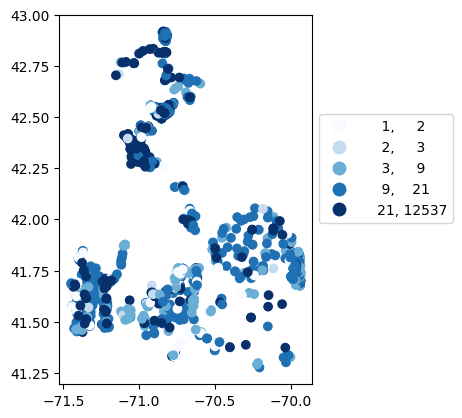

In [22]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df, stations_clipped)
legend_kwds = {"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)}
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize_generic().
harmonize_all runs functions on all characteristics and lets you specify how to handle errors
harmonize_generic runs functions only on the characteristic specified with char_val and lets you also
choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [23]:
# See Documentation
#harmonize_WQP.harmonize_all?
#harmonize_WQP.harmonize?

##### secchi disk depth

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\wq_data.py:379: UserWarning: WARNING: 'None' UNDEFINED UNIT for Secchi
  warn("WARNING: " + problem)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    4859.000000
mean      -12.392416
std       405.605559
min     -9999.000000
25%         1.600000
50%         3.500000
75%         6.000000
max        17.000000
dtype: float64
Unusable results: 264
Usable results with inferred units: 0
Results outside threshold (0.0 to 2421.2409350894627): 16


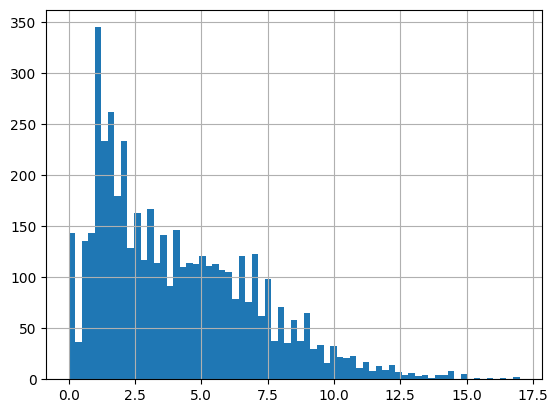

In [24]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize(df, 'Depth, Secchi disk depth', intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [25]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
14,11113300-GRTKINSD,3.25,m,NaN,m,3.25 meter
125,11113300-BEADERD,4.25,m,NaN,m,4.25 meter
303,11113300-ANGSDND,3.5,m,NaN,m,3.5 meter
554,11113300-GRTKINSD,2.25,m,NaN,m,2.25 meter
562,11113300-GRTKINSD,4.75,m,NaN,m,4.75 meter
...,...,...,...,...,...,...
412761,11NPSWRD_WQX-CACO_DUCK_W,16.5,m,NaN,m,16.5 meter
412762,11NPSWRD_WQX-CACO_DUCK_W,10.0,m,NaN,m,10.0 meter
412763,11NPSWRD_WQX-CACO_DUCK_W,17.0,m,NaN,m,17.0 meter
412764,11NPSWRD_WQX-CACO_DUCK_W,16.0,m,NaN,m,16.0 meter


In [26]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
10249,NARS_WQX-NLA12_MA-102,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
28878,EPA_OCMA_R1-SS-2,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
31761,EPA_OCMA_R1-SS-3,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
33655,EPA_OCMA_R1-R1-23,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
35891,EPA_OCMA_R1-R1-25,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
...,...,...,...,...,...,...
325018,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
325099,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
325464,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
326200,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN


In [27]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: missing (NaN) result; ResultMeasure/MeasureUnitCode: MISSING UNITS, m assumed'

In [28]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
10249,NARS_WQX-NLA12_MA-102,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
28857,NARS_WQX-NCCA10-1070,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
28878,EPA_OCMA_R1-SS-2,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
29028,NARS_WQX-NCCA10-1029,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
30225,NARS_WQX-NCCA10-1001,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
...,...,...,...,...,...,...
325018,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
325099,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
325464,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
326200,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN


If both value and unit are missing nothing can be done, a unitless (NaN) value is assumed as to be in default units but a QA_flag is added

In [29]:
# Aggregate secchi data by station
visualize.station_summary(sechi_results, 'Secchi')

,MonitoringLocationIdentifier,cnt,mean
0,11113300-ANGSDND,42,3.796369
1,11113300-BEADERD,42,3.644048
2,11113300-CANWIND,22,6.144000
3,11113300-CAPSALD,24,2.456262
4,11113300-COBWINND,21,3.768810
...,...,...,...
689,WWMD_VA-SH1,2,1.500000
690,WWMD_VA-SH2,2,1.800000
691,WWMD_VA-SR6A,1,0.500000
692,WWMD_VA-WF2,1,0.600000


C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\mapclassify\classifiers.py:257: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  warnings.warn(


<Axes: >

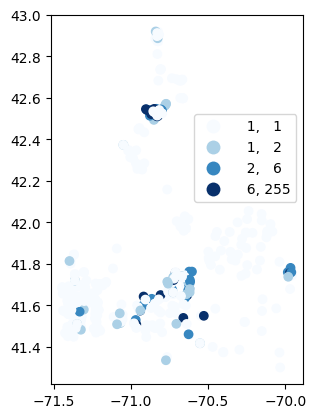

In [30]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(sechi_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

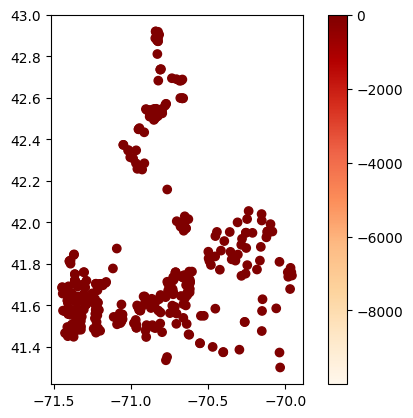

In [31]:
# Map average results at each station
gdf_avg = visualize.map_measure(sechi_results, stations_clipped, 'Secchi')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\convert.py:125: UserWarning: WARNING: 'count' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    118916.000000
mean         16.047985
std           7.339153
min          -6.000000
25%          11.000000
50%          16.777500
75%          21.700000
max         910.000000
dtype: float64
Unusable results: 213
Usable results with inferred units: 217
Results outside threshold (0.0 to 60.08290250951757): 115


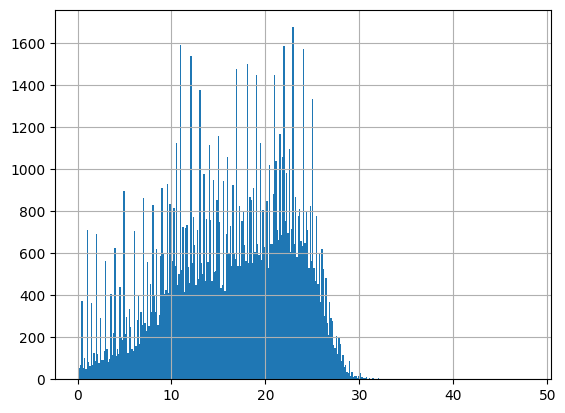

In [32]:
#'Temperature, water'
# errors=‘ignore’, invalid dimension conversions will return the NaN.
df = harmonize.harmonize(df, 'Temperature, water', intermediate_columns=True, report=True, errors='ignore')

In [33]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
12,CRWA-4LONG,28.2,deg C,NaN,28.2 degree_Celsius,degC
18,11113300-BCHHSPHAMLF,15,deg C,NaN,15.0 degree_Celsius,degC
19,MASSDEP-W0762,23.7,deg C,NaN,23.7 degree_Celsius,degC
26,11NPSWRD_WQX-NETN_MIMA_29,11.56,deg C,NaN,11.56 degree_Celsius,degC
27,CRWA-675S,17.3,deg C,NaN,17.3 degree_Celsius,degC
...,...,...,...,...,...,...
413433,USGS-413831070304703,11.3,deg C,NaN,11.3 degree_Celsius,degC
413435,USGS-01100627,7.0,deg C,NaN,7.0 degree_Celsius,degC
413439,USGS-01096548,2.9,deg C,NaN,2.9 degree_Celsius,degC
413443,USGS-01098530,1.5,deg C,NaN,1.5 degree_Celsius,degC


In [34]:
# Examine deg F
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'] == 'deg F']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
15771,NALMS-F865245,81,deg F,NaN,27.222222222222285 degree_Celsius,degF
22382,11113300-HOODERD,59.2,deg F,NaN,15.111111111111143 degree_Celsius,degF
22710,11113300-HOODERD,59.1,deg F,NaN,15.0555555555556 degree_Celsius,degF
22994,11113300-HOODERD,59.9,deg F,NaN,15.500000000000057 degree_Celsius,degF
23434,11113300-HOODERD,56,deg F,NaN,13.333333333333371 degree_Celsius,degF
...,...,...,...,...,...,...
409274,11NPSWRD_WQX-SAIR_MEQ76_NC6,70.0,deg F,NaN,21.111111111111143 degree_Celsius,degF
409283,11NPSWRD_WQX-SAMA_MEQ76_NC18,71.0,deg F,NaN,21.666666666666686 degree_Celsius,degF
409289,11NPSWRD_WQX-SAMA_MEQ76_NC13,72.0,deg F,NaN,22.222222222222285 degree_Celsius,degF
409300,11NPSWRD_WQX-SAIR_MEQ76_NC3,70.0,deg F,NaN,21.111111111111143 degree_Celsius,degF


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [35]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
98296,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
98297,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
98298,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
98299,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
98300,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
...,...,...,...,...,...,...
99638,AQUINNAH-MEN PND Q,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
99639,AQUINNAH-MEN PND Q,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
99641,AQUINNAH-MEN PND Q,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
142918,AQUINNAH-MEN PND HC,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [36]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [37]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
251,MERRIMACK_RIVER_WATERSHED_WQX-Hayden-Schofield,8,count,NaN,NaN,count
2860,MERRIMACK_RIVER_WATERSHED_WQX-Manchester,8,count,NaN,NaN,count
3393,MERRIMACK_RIVER_WATERSHED_WQX-Nina-Scarito,8,count,NaN,NaN,count
4137,MERRIMACK_RIVER_WATERSHED_WQX-Misserville,8,count,NaN,NaN,count
4445,MERRIMACK_RIVER_WATERSHED_WQX-Ferrous,8,count,NaN,NaN,count
...,...,...,...,...,...,...
244467,11NPSWRD_WQX-SAIR_SWC_SR3,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
259810,11NPSWRD_WQX-SAIR_SWC_SR6,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
261067,11NPSWRD_WQX-SAIR_SWC_SR7,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
265540,11NPSWRD_WQX-SAIR_SWC_SRT9,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC


In [38]:
# Aggregate temperature data by station
visualize.station_summary(temperature_results, 'Temperature')

,MonitoringLocationIdentifier,cnt,mean
0,11113300-00-SPB,21,10.909524
1,11113300-00F-KLY,3,20.233333
2,11113300-01-BAK,10,20.600000
3,11113300-01-BVR,1,21.000000
4,11113300-01-CTP,39,24.438462
...,...,...,...
5916,WWMD_VA-WWE1149PI,1,18.800000
5917,WWMD_VA-WWE1150PI,1,21.300000
5918,WWMD_VA-WWE1151PI,2,20.700000
5919,WWMD_VA-WWE1152PI,1,20.000000


<Axes: >

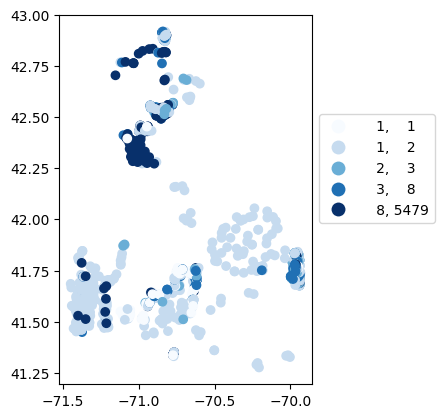

In [39]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(temperature_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

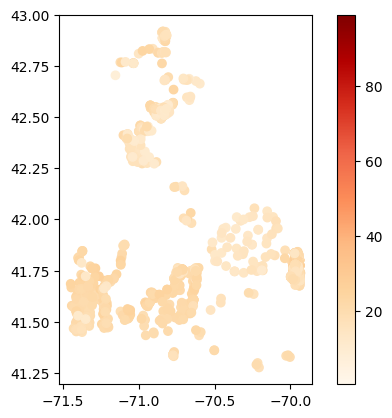

In [40]:
# Map average results at each station
gdf_avg = visualize.map_measure(temperature_results, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Dissolved Oxygen (DO)

In [41]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize(df, 'Dissolved oxygen (DO)')

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [42]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
2,IRWA-HB,4.6,mg/L,NaN,4.6 milligram / liter
5,MYRWA-MEB001,9.4,mg/L,NaN,9.4 milligram / liter
6,NARS_WQX-MARO-1020,10.3,mg/L,NaN,10.3 milligram / liter
8,MASSDEP-W2412,8.7,mg/L,NaN,8.7 milligram / liter
9,MERRIMACK_RIVER_WATERSHED_WQX-Central Catholic,10.91,mg/L,NaN,10.91 milligram / liter
...,...,...,...,...,...
409930,11NPSWRD_WQX-CACO_GREAT_W,6.1,mg/L,NaN,6.1 milligram / liter
409933,11NPSWRD_WQX-SAMA_EPG_SHC,14.2,mg/L,NaN,14.2 milligram / liter
409935,11NPSWRD_WQX-SAMA_EPG_SHD,8.5,mg/L,NaN,8.5 milligram / liter
409940,11NPSWRD_WQX-SAMA_EPG_SHC,9.1,mg/L,NaN,9.1 milligram / liter


In [43]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
2,IRWA-HB,4.6,mg/L,NaN,4.6 milligram / liter
5,MYRWA-MEB001,9.4,mg/L,NaN,9.4 milligram / liter
6,NARS_WQX-MARO-1020,10.3,mg/L,NaN,10.3 milligram / liter
8,MASSDEP-W2412,8.7,mg/L,NaN,8.7 milligram / liter
9,MERRIMACK_RIVER_WATERSHED_WQX-Central Catholic,10.91,mg/L,NaN,10.91 milligram / liter
...,...,...,...,...,...
409930,11NPSWRD_WQX-CACO_GREAT_W,6.1,mg/L,NaN,6.1 milligram / liter
409933,11NPSWRD_WQX-SAMA_EPG_SHC,14.2,mg/L,NaN,14.2 milligram / liter
409935,11NPSWRD_WQX-SAMA_EPG_SHD,8.5,mg/L,NaN,8.5 milligram / liter
409940,11NPSWRD_WQX-SAMA_EPG_SHC,9.1,mg/L,NaN,9.1 milligram / liter


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [44]:
# Aggregate data by station
visualize.station_summary(do_res, 'DO')

,MonitoringLocationIdentifier,cnt,mean
0,11113300-00F-KLY,3,4.040000
1,11113300-01-BAK,10,5.697000
2,11113300-01-BVR,1,6.700000
3,11113300-01-CTP,37,6.945135
4,11113300-01-GOL,1,4.400000
...,...,...,...
2311,WWMD_VA-SR5,1,10.810000
2312,WWMD_VA-WF2,2,6.800000
2313,WWMD_VA-WI1,1,9.510000
2314,WWMD_VA-WR2X,2,6.000000


<Axes: >

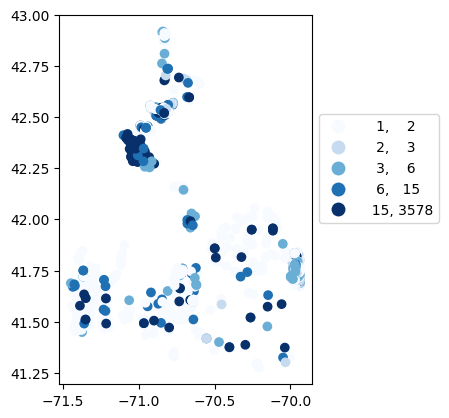

In [45]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(do_res, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

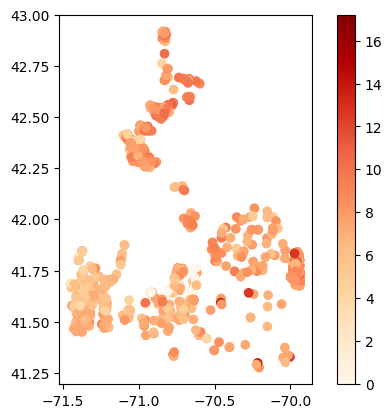

In [46]:
# Map average results at each station
gdf_avg = visualize.map_measure(do_res, stations_clipped, 'DO')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### pH

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    94569.000000
mean         6.509378
std          2.642258
min         -3.124705
25%          5.700000
50%          6.620000
75%          7.320000
max        715.000000
dtype: float64
Unusable results: 17
Usable results with inferred units: 215
Results outside threshold (0.0 to 22.362923608048774): 12


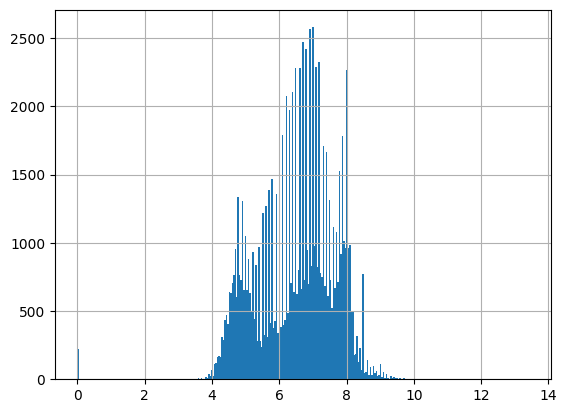

In [47]:
# pH, this time looking at a report
df = harmonize.harmonize(df, 'pH', report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [48]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
30,7.69,None,NaN,7.69 dimensionless
31,7.4,None,NaN,7.4 dimensionless
40,7.78,None,NaN,7.78 dimensionless
54,7.9,None,NaN,7.9 dimensionless
59,6.16,None,NaN,6.16 dimensionless
...,...,...,...,...
413434,5.8,std units,NaN,5.8 dimensionless
413436,7.3,std units,NaN,7.3 dimensionless
413440,7.4,std units,NaN,7.4 dimensionless
413444,7.5,std units,NaN,7.5 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

##### Salinity

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\basis.py:162: UserWarning: Mismatched ResultTemperatureBasisText: updated from 25 deg C to @25C (units)
  warn(f'Mismatched {flag}', UserWarning)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\convert.py:125: UserWarning: WARNING: 'deg C' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count    30755.000000
mean        19.334149
std         27.164539
min          0.000000
25%          0.535000
50%         29.000000
75%         31.100000
max       4003.482834
dtype: float64
Unusable results: 217
Usable results with inferred units: 1
Results outside threshold (0.0 to 182.3213833602183): 2


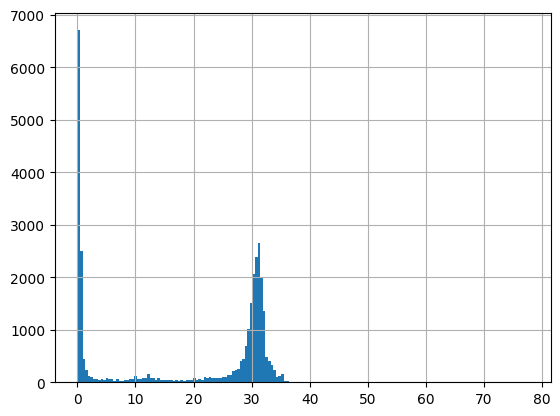

In [49]:
# Salinity
df = harmonize.harmonize(df, 'Salinity', report=True, errors='ignore')

In [50]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
37,33.3,ppth,NaN,33.3 Practical_Salinity_Units
51,32.7,ppth,NaN,32.7 Practical_Salinity_Units
79,0.21,ppth,NaN,0.21 Practical_Salinity_Units
86,31.24,ppt,NaN,31.24 Practical_Salinity_Units
104,30.48,ppt,NaN,30.48 Practical_Salinity_Units
...,...,...,...,...
412242,9.9,PSU,NaN,9.9 Practical_Salinity_Units
412847,4.6,PSU,NaN,4.6 Practical_Salinity_Units
412947,21.0,PSU,NaN,21.0 Practical_Salinity_Units
412960,18.7,PSU,NaN,18.7 Practical_Salinity_Units


##### Nitrogen

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\wq_data.py:379: UserWarning: WARNING: 'cm3/g' UNDEFINED UNIT for Nitrogen
  warn("WARNING: " + problem)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\construction.py:616: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    2409.000000
mean        6.472302
std       106.930304
min         0.000800
25%         0.074000
50%         0.242000
75%         1.000000
max      2800.000000
dtype: float64
Unusable results: 243
Usable results with inferred units: 0
Results outside threshold (0.0 to 648.0541246058881): 6


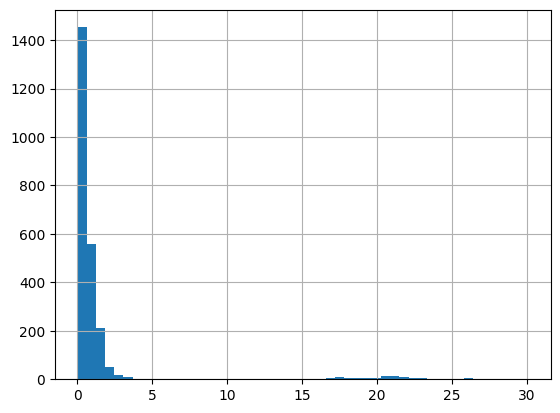

In [51]:
# Nitrogen
df = harmonize.harmonize(df, 'Nitrogen', report=True)

In [52]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
648,0.926976,mg/L,NaN,0.926976 milligram / liter
768,1.571196,mg/L,NaN,1.571196 milligram / liter
771,0.816144,mg/L,NaN,0.816144 milligram / liter
1020,0.848832,mg/L,NaN,0.848832 milligram / liter
1066,0.770448,mg/L,NaN,0.770448 milligram / liter
...,...,...,...,...
413267,0.119,mg/l,NaN,0.119 milligram / liter
413325,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
413368,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
413374,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN


##### Conductivity

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\convert.py:125: UserWarning: WARNING: 'count' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count     1953.000000
mean      1335.828913
std       4876.924920
min          0.000000
25%        310.000000
50%        430.000000
75%        577.000000
max      48600.000000
dtype: float64
Unusable results: 80
Usable results with inferred units: 0
Results outside threshold (0.0 to 30597.378435757106): 16


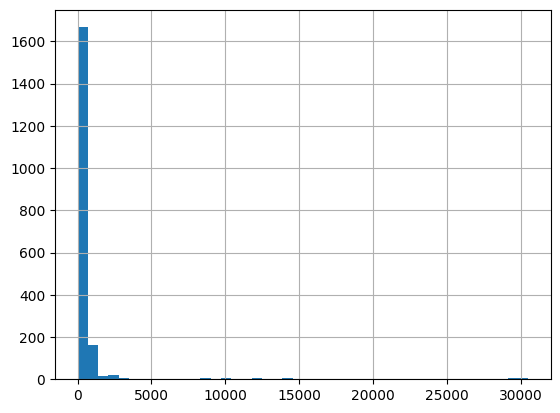

In [53]:
# Conductivity
df = harmonize.harmonize(df, 'Conductivity', report=True, errors='ignore')

In [54]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
7,349,uS/cm,NaN,349.0 microsiemens / centimeter
16,8,count,NaN,NaN
23,443,uS/cm,NaN,443.0 microsiemens / centimeter
47,67.11703531,uS/cm,NaN,67.11703531 microsiemens / centimeter
93,590,uS/cm,NaN,590.0 microsiemens / centimeter
...,...,...,...,...
307112,0.431,mS/cm,NaN,431.0 microsiemens / centimeter
307137,0.321,mS/cm,NaN,321.0 microsiemens / centimeter
307139,0.364,mS/cm,NaN,364.0 microsiemens / centimeter
307157,0.246,mS/cm,NaN,246.0 microsiemens / centimeter


##### Chlorophyll a

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\wq_data.py:379: UserWarning: WARNING: 'ppb' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\wq_data.py:379: UserWarning: WARNING: 'ug/cm2' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\wq_data.py:379: UserWarning: WARNING: 'ug/m3' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    4156.000000
mean        0.583832
std         3.286460
min        -0.002400
25%         0.001900
50%         0.005200
75%         0.019000
max        92.900000
dtype: float64
Unusable results: 202
Usable results with inferred units: 9
Results outside threshold (0.0 to 20.302593411738652): 29


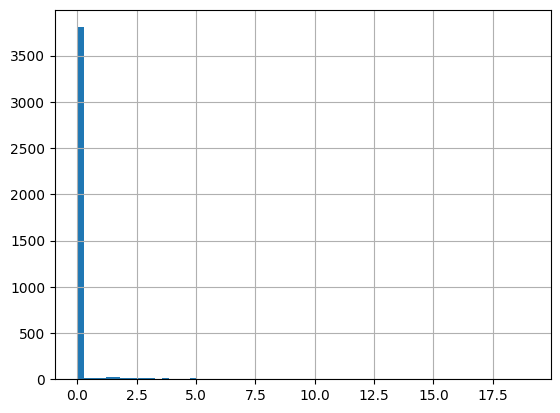

In [55]:
# Chlorophyll a
df = harmonize.harmonize(df, 'Chlorophyll a', report=True)

In [56]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
1,4.0,mg/m3,NaN,0.004000000000000001 milligram / liter
148,5.50,ug/L,NaN,0.0055 milligram / liter
314,9.48,ug/L,NaN,0.00948 milligram / liter
558,3.0,mg/m3,NaN,0.003000000000000001 milligram / liter
781,NaN,mg/m3,ResultMeasureValue: missing (NaN) result,NaN
...,...,...,...,...
413151,0.5,ug/l,NaN,0.0005 milligram / liter
413158,2.5,ug/l,NaN,0.0025 milligram / liter
413171,0.7,ug/l,NaN,0.0007 milligram / liter
413204,1.1,ug/l,NaN,0.0011 milligram / liter


##### Organic Carbon

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count      6126.000000
mean       5300.199057
std       35634.927260
min      -90000.000000
25%           1.720000
50%           4.900000
75%           8.900000
max      530000.000000
dtype: float64
Unusable results: 79
Usable results with inferred units: 0
Results outside threshold (0.0 to 219109.7626196926): 40


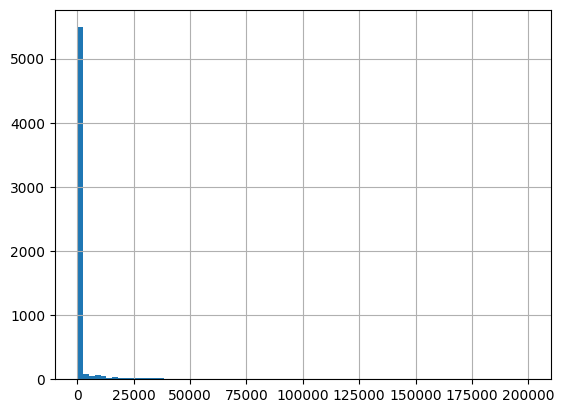

In [57]:
# Organic carbon (%)
df = harmonize.harmonize(df, 'Organic carbon', report=True)

In [58]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
839,7.05,mg/L,NaN,7.05 milligram / liter
916,7.57,mg/L,NaN,7.57 milligram / liter
963,3.5,mg/L,NaN,3.5 milligram / liter
2456,3.8,mg/L,NaN,3.8 milligram / liter
3210,3.7,mg/L,NaN,3.7 milligram / liter
...,...,...,...,...
413255,7.01,mg/l,NaN,7.01 milligram / liter
413324,5.96,mg/l,NaN,5.96 milligram / liter
413367,4.1,mg/l,NaN,4.1 milligram / liter
413373,7.79,mg/l,NaN,7.79 milligram / liter


##### Turbidity (NTU)

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:146: UserWarning: Bad Turbidity unit: count
  warn(f'Bad Turbidity unit: {unit}')
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\convert.py:125: UserWarning: WARNING: 'count' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count    25009.000000
mean        20.559190
std         83.962653
min       -999.000000
25%          1.560000
50%          3.250000
75%          7.200000
max       4100.000000
dtype: float64
Unusable results: 547
Usable results with inferred units: 275
Results outside threshold (0.0 to 524.335104937954): 159


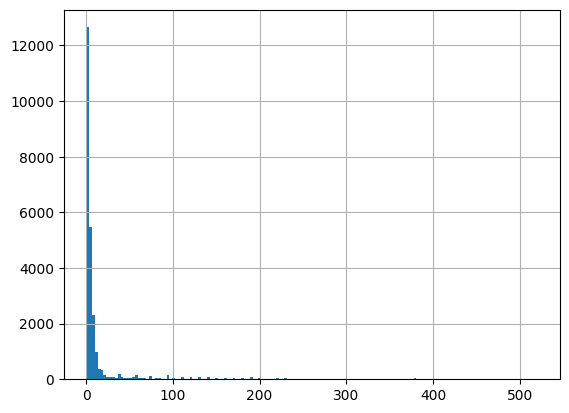

In [59]:
# Turbidity (NTU)
df = harmonize.harmonize(df, 'Turbidity', report=True, errors='ignore')

In [60]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
0,4.2,NTU,NaN,4.2 Nephelometric_Turbidity_Units
4,1.3,NTU,NaN,1.3 Nephelometric_Turbidity_Units
17,2.1,NTU,NaN,2.1 Nephelometric_Turbidity_Units
21,1.3,NTU,NaN,1.3 Nephelometric_Turbidity_Units
28,.69,NTU,NaN,0.69 Nephelometric_Turbidity_Units
...,...,...,...,...
413428,1.6,NTRU,NaN,1.6 Nephelometric_Turbidity_Units
413438,5.8,NTRU,NaN,5.8 Nephelometric_Turbidity_Units
413442,2.1,NTRU,NaN,2.1 Nephelometric_Turbidity_Units
413446,2.9,NTRU,NaN,2.9 Nephelometric_Turbidity_Units


##### Sediment

In [61]:
# Sediment
df = harmonize.harmonize(df, 'Sediment', report=False, errors='ignore')

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\convert.py:125: UserWarning: WARNING: 'g / H2O' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


In [62]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']
df.loc[df['CharacteristicName']=='Sediment', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment
371046,0.012,g,NaN,NaN
371047,0.0037,g,NaN,NaN
371048,0.0048,g,NaN,NaN
371049,0.001,g,NaN,NaN
371050,0.0088,g,NaN,NaN
...,...,...,...,...
412517,0.0051,g,NaN,NaN
412591,0.0025,g,NaN,NaN
412663,0.002,g,NaN,NaN
412702,0.0023,g,NaN,NaN


##### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [63]:
# Phosphorus
df = harmonize.harmonize(df, 'Phosphorus')

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\construction.py:616: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


2 Phosphorus sample fractions not in frac_dict
2 Phosphorus sample fractions not in frac_dict found in expected domains, mapped to "Other_Phosphorus"


Note: warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [64]:
# All Phosphorus
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']
df.loc[df['Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
20,0.05,mg/L,NaN,NaN
24,0.027,mg/L,NaN,NaN
39,0.024,mg/L,NaN,NaN
49,0.059712,mg/L,NaN,NaN
107,0.049,mg/L,NaN,NaN
...,...,...,...,...
412724,0.006,mg/l as P,NaN,0.006 milligram / liter
412736,0.016,mg/l as P,NaN,NaN
412737,0.008,mg/l as P,NaN,0.008 milligram / liter
412744,0.047,mg/l as P,NaN,NaN


In [65]:
# Total phosphorus
df.loc[df['TP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
20,0.05,mg/L,NaN,NaN
24,0.027,mg/L,NaN,NaN
39,0.024,mg/L,NaN,NaN
49,0.059712,mg/L,NaN,NaN
107,0.049,mg/L,NaN,NaN
...,...,...,...,...
412698,0.036,mg/l as P,NaN,NaN
412709,0.021,mg/l as P,NaN,NaN
412723,0.011,mg/l as P,NaN,NaN
412736,0.016,mg/l as P,NaN,NaN


In [66]:
# Total dissolved phosphorus
df.loc[df['TDP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
39036,0.023,ppm,NaN,0.023000000000000003 milligram / liter
41424,0.035,ppm,NaN,0.03500000000000001 milligram / liter
42544,0.017,ppm,NaN,0.017000000000000005 milligram / liter
42631,0.015,ppm,NaN,0.015000000000000003 milligram / liter
43518,0.015,ppm,NaN,0.015000000000000003 milligram / liter
...,...,...,...,...
412699,0.015,mg/l as P,NaN,0.015 milligram / liter
412710,0.005,mg/l as P,NaN,0.005 milligram / liter
412724,0.006,mg/l as P,NaN,0.006 milligram / liter
412737,0.008,mg/l as P,NaN,0.008 milligram / liter


In [67]:
# All other phosphorus sample fractions
df.loc[df['Other_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
28362,0.03525375,mg/L,NaN,NaN
28450,0.107028125,mg/L,NaN,NaN
28991,0.0697675,mg/L,NaN,NaN
29215,0.04356,mg/L,NaN,NaN
29294,0.03654875,mg/L,NaN,NaN
...,...,...,...,...
401748,530.0,mg/kg,NaN,NaN
403085,280.0,mg/kg,NaN,NaN
403859,270.0,mg/kg,NaN,NaN
404105,260.0,mg/kg,NaN,NaN


##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\convert.py:125: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\convert.py:125: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\convert.py:125: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count      2462.000000
mean        910.512591
std        6103.365912
min           0.000000
25%          24.000000
50%          93.000000
75%         400.000000
max      250000.000000
dtype: float64
Unusable results: 5762
Usable results with inferred units: 1
Results outside threshold (0.0 to 37530.70806108734): 7


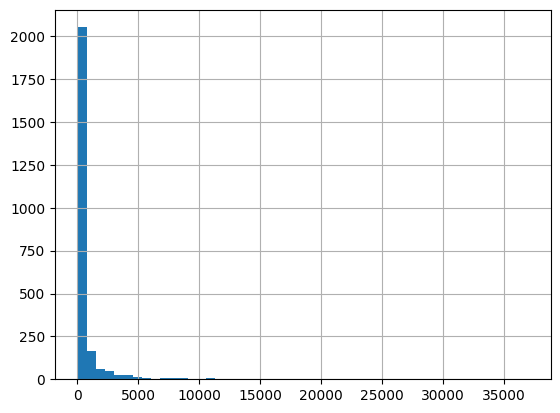

In [68]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Fecal Coliform', report=True, errors='ignore')

In [69]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
8028,40,#/100mL,NaN,NaN
8083,9,#/100mL,NaN,NaN
8087,20,#/100mL,NaN,NaN
8210,200,#/100mL,NaN,NaN
8387,NO DATA,#/100mL,"ResultMeasureValue: ""NO DATA"" result cannot be...",NaN
...,...,...,...,...
409287,230.0,cfu/100mL,NaN,NaN
409290,2400.0,cfu/100mL,NaN,NaN
409293,30.0,cfu/100mL,NaN,NaN
409297,NaN,cfu/100mL,ResultMeasureValue: missing (NaN) result,NaN


###### Excherichia Coli

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\convert.py:125: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\convert.py:125: UserWarning: WARNING: '%' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\convert.py:125: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\convert.py:125: UserWarning: WARNING: 'count' converted to NaN
  warn(f

-Usable results-
count     1278.000000
mean       626.068286
std       3462.583347
min          0.000000
25%         22.250000
50%         66.000000
75%        220.000000
max      72000.000000
dtype: float64
Unusable results: 22187
Usable results with inferred units: 0
Results outside threshold (0.0 to 21401.56837068052): 7


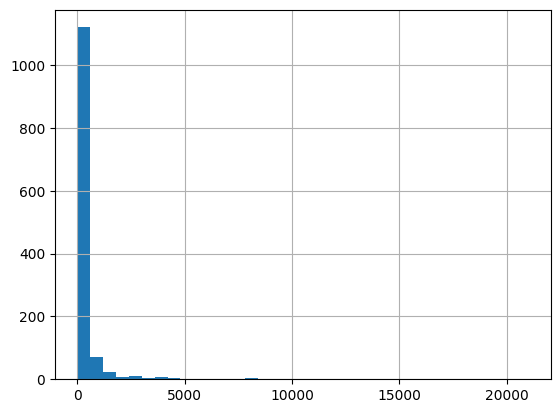

In [70]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Escherichia coli', report=True, errors='ignore')

In [71]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
3,96,MPN/100mL,NaN,NaN
13,110,MPN/100mL,NaN,NaN
15,52,MPN/100mL,NaN,NaN
35,24200,MPN/100mL,NaN,NaN
38,52,MPN/100mL,NaN,NaN
...,...,...,...,...
413424,7.0,MPN/100 ml,NaN,7.0 Colony_Forming_Units / milliliter
413437,870.0,MPN/100 ml,NaN,870.0 Colony_Forming_Units / milliliter
413441,44.0,MPN/100 ml,NaN,44.0 Colony_Forming_Units / milliliter
413445,14.0,MPN/100 ml,NaN,14.0 Colony_Forming_Units / milliliter


#### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

Explore Salinity results:

In [72]:
from harmonize_wq import convert

In [73]:
# First note initial Salinity info
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: 0.0 to 4003.4828342857154
Results: 30755 
Mean: 19.334148801040758 PSU


In [74]:
# Identify extreme outliers
[x for x in lst if x >3200]

[4003.4828342857154]

Other fields like units and QA_flag may help understand what caused high values and what results might need to be dropped from consideration

In [75]:
# Columns to focus on
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']

In [76]:
# Look at important fields for max 5 values
salinity_series = df['Salinity'][df['Salinity'].notna()]
salinity_series.sort_values(ascending=False, inplace=True)
df[cols][df['Salinity'].isin(salinity_series[0:5])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
22353,804,ppth,NaN,804.0 Practical_Salinity_Units
142474,71.49,ppth,NaN,71.49 Practical_Salinity_Units
143483,70.62,ppth,NaN,70.62 Practical_Salinity_Units
175267,77.6666666666667,ppt,NaN,77.6666666666667 Practical_Salinity_Units
379427,4980.0,mg/mL @25C,ResultTemperatureBasisText: updated from 25 de...,4003.4828342857154 Practical_Salinity_Units


Detection limits may help understand what caused low values and what results might need to be dropped or updated

In [77]:
df = wrangle.add_detection(df, 'Salinity')
cols+=['ResultDetectionConditionText',
       'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode']

In [78]:
# Look at important fields for min 5 values (often multiple 0.0)
df[cols][df['Salinity'].isin(salinity_series[-5:])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,ResultDetectionConditionText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode
10790,0,ppt,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
11206,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
11394,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
16806,0,ppm,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
18006,0,ppm,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
320397,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
320476,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
320516,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
320541,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN


Explore conductivity results:

In [79]:
# Create series for Conductivity values
cond_series = df['Conductivity'].dropna()
cond_series

7               349.0 microsiemens / centimeter
23              443.0 microsiemens / centimeter
47        67.11703531 microsiemens / centimeter
93              590.0 microsiemens / centimeter
112           418.375 microsiemens / centimeter
                          ...                  
307112          431.0 microsiemens / centimeter
307137          321.0 microsiemens / centimeter
307139          364.0 microsiemens / centimeter
307157          246.0 microsiemens / centimeter
307158          607.0 microsiemens / centimeter
Name: Conductivity, Length: 1953, dtype: object

Conductivity thresholds from Freshwater Explorer: 10 > x < 5000 us/cm, use a higher threshold for coastal waters

In [80]:
# Sort and check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.sort_values(by=['Conductivity'], ascending=False, inplace=True)
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
103595,48.6,mS/cm,NaN,NaN,48600.0 microsiemens / centimeter
105049,48.15,mS/cm,NaN,NaN,48150.0 microsiemens / centimeter
67796,48,mS/cm,NaN,NaN,48000.0 microsiemens / centimeter
72594,46.9,mS/cm,NaN,NaN,46900.0 microsiemens / centimeter
104091,46.8,mS/cm,NaN,NaN,46800.0 microsiemens / centimeter
...,...,...,...,...,...
4703,0.03,uS/cm,NaN,NaN,0.03 microsiemens / centimeter
5171,0.02,uS/cm,NaN,NaN,0.02 microsiemens / centimeter
2651,0.02,uS/cm,NaN,NaN,0.02 microsiemens / centimeter
3052,0,uS/cm,NaN,NaN,0.0 microsiemens / centimeter


In [81]:
# Convert values to PSU and write to Salinity
cond_series = cond_series.apply(str)  # Convert to string to convert to dimensionless (PSU)
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)
df.loc[df['Conductivity'].notna(), 'Salinity']

103595    31.712 dimensionless
105049    31.384 dimensionless
67796     31.274 dimensionless
72594     30.474 dimensionless
104091    30.401 dimensionless
                  ...         
4703       0.012 dimensionless
5171       0.012 dimensionless
2651       0.012 dimensionless
3052       0.012 dimensionless
6576       0.012 dimensionless
Name: Salinity, Length: 1953, dtype: object

#### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [82]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
103595,2007-08-23,09:23:00,EST
105049,2007-08-09,08:14:00,EST
67796,2006-08-21,11:50:00,EST
72594,2006-08-07,10:00:00,EST
104091,2007-08-09,10:20:00,EST
...,...,...,...
413446,2024-01-08,12:00:00,EST
413447,2024-02-12,08:45:00,EST
413448,2024-02-12,08:45:00,EST
413449,2024-02-12,08:45:00,EST


In [83]:
# 'ActivityStartDate' presserves date where 'Activity_datetime' is NAT due to no time zone
df = clean.datetime(df)
df[['ActivityStartDate', 'Activity_datetime']]

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\dataretrieval\utils.py:87: UserWarning: Warning: 132728 incomplete dates found, consider setting datetime_index to False.
  warnings.warn(


,ActivityStartDate,Activity_datetime
103595,2007-08-23,2007-08-23 14:23:00+00:00
105049,2007-08-09,2007-08-09 13:14:00+00:00
67796,2006-08-21,2006-08-21 16:50:00+00:00
72594,2006-08-07,2006-08-07 15:00:00+00:00
104091,2007-08-09,2007-08-09 15:20:00+00:00
...,...,...
413446,2024-01-08,2024-01-08 17:00:00+00:00
413447,2024-02-12,2024-02-12 13:45:00+00:00
413448,2024-02-12,2024-02-12 13:45:00+00:00
413449,2024-02-12,2024-02-12 13:45:00+00:00


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a ActivityStartDate column is used to preserve date only.

#### Depth

Note: Data are often lacking sample depth metadata

In [84]:
# Depth of sample (default units='meter')
df = clean.harmonize_depth(df)
#df.loc[df['ResultDepthHeightMeasure/MeasureValue'].dropna(), "Depth"]
df['ResultDepthHeightMeasure/MeasureValue'].dropna()

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


103595    0.15
105049    0.15
67796     0.15
72594     0.15
104091    0.15
          ... 
279222    0.15
279263    0.15
279277    0.15
279291    0.15
279320    0.15
Name: ResultDepthHeightMeasure/MeasureValue, Length: 2460, dtype: float64

#### Characteristic to Column (long to wide format)

In [85]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Conductivity,QA_Salinity,QA_pH,QA_DO,QA_Nitrogen,QA_Temperature,QA_Fecal_Coliform
103595,WWMD_VA,WQX Test Organization,WWMD_VA-BI1:20070823092300:SO:1.5:WB,2007-08-23,09:23:00,-0500,WWMD_VA-BI1,STORET-1013198907,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105049,WWMD_VA,WQX Test Organization,WWMD_VA-BI1:20070809081400:SO:1.7:WB,2007-08-09,08:14:00,-0500,WWMD_VA-BI1,STORET-1013198861,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67796,WWMD_VA,WQX Test Organization,WWMD_VA-SR6A:20060821115000:SO:0.8:WB,2006-08-21,11:50:00,-0500,WWMD_VA-SR6A,STORET-1013198845,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72594,WWMD_VA,WQX Test Organization,WWMD_VA-OB6:20060807100000:SO:1.7:WB,2006-08-07,10:00:00,-0500,WWMD_VA-OB6,STORET-1013198765,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104091,WWMD_VA,WQX Test Organization,WWMD_VA-LT1N:20070809102000:SO:0.75:WB,2007-08-09,10:20:00,-0500,WWMD_VA-LT1N,STORET-1013198891,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413446,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400495,2024-01-08,12:00:00,-0500,USGS-01098530,NWIS-126836828,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
413447,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,-0500,USGS-01097050,NWIS-126989046,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
413448,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,-0500,USGS-01097050,NWIS-126989056,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
413449,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,-0500,USGS-01097050,NWIS-126989063,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

15 new columns


In [87]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

35873 fewer rows


In [88]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [89]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [90]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier', 'ProviderName',
       'Secchi', 'Temperature', 'DO', 'pH', 'Salinity', 'Nitrogen',
       'Speciation', 'TOTAL NITROGEN_ MIXED FORMS', 'Conductivity',
       'Chlorophyll', 'Carbon', 'Turbidity', 'Sediment', 'Phosphorus',
       'TP_Phosphorus', 'TDP_Phosphorus', 'Other_Phosphorus', 'Fecal_Coliform',
       'E_coli', 'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode',
       'Activity_datetime', 'Depth', 'QA_Secchi', 'QA_Turbidity',
       'QA_Sediment', 'QA_E_coli', 'QA_Carbon', 'QA_Chlorophyll',
       'QA_TP_Phosphorus', 'QA_TDP_Phosphorus', 'QA_Other_Phosphorus',
       'QA_Conductivity', 'QA_Salinity', 'QA_pH', 'QA_DO', 'QA_Nitrogen',
       'QA_Temperature', 'QA_Fecal_Coliform'],
      dtype='object')

In [91]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ProviderName,Secchi,Temperature,DO,pH,Salinity,...,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Conductivity,QA_Salinity,QA_pH,QA_DO,QA_Nitrogen,QA_Temperature,QA_Fecal_Coliform
103595,WWMD_VA,WQX Test Organization,WWMD_VA-BI1:20070823092300:SO:1.5:WB,WWMD_VA-BI1,STORET,NaN,NaN,NaN,NaN,31.712 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105049,WWMD_VA,WQX Test Organization,WWMD_VA-BI1:20070809081400:SO:1.7:WB,WWMD_VA-BI1,STORET,NaN,NaN,NaN,NaN,31.384 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67796,WWMD_VA,WQX Test Organization,WWMD_VA-SR6A:20060821115000:SO:0.8:WB,WWMD_VA-SR6A,STORET,NaN,NaN,NaN,NaN,31.274 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72594,WWMD_VA,WQX Test Organization,WWMD_VA-OB6:20060807100000:SO:1.7:WB,WWMD_VA-OB6,STORET,NaN,NaN,NaN,NaN,30.474 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104091,WWMD_VA,WQX Test Organization,WWMD_VA-LT1N:20070809102000:SO:0.75:WB,WWMD_VA-LT1N,STORET,NaN,NaN,NaN,NaN,30.401 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['Sediment',
 'DetectionQuantitationLimitTypeName',
 'DetectionQuantitationLimitMeasure/MeasureValue',
 'DetectionQuantitationLimitMeasure/MeasureUnitCode',
 'QA_Sediment',
 'QA_E_coli',
 'QA_Carbon',
 'QA_TDP_Phosphorus',
 'QA_Conductivity',
 'QA_DO']

<Axes: >

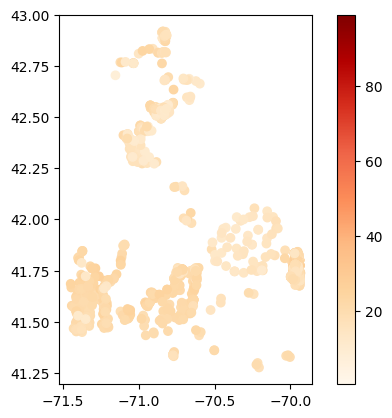

In [93]:
# Map average results at each station
gdf_avg = visualize.map_measure(main_df, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)